1. Extract patches and their labels from the shapefile.
2. Extract features using ResNet-50.
3. Save these features and labels to an HDF5 file.
4. Load a random patch, find the three most relevant patches, and display them.

In [4]:
import torch.nn as nn
import geopandas as gpd
from shapely.geometry import mapping
import rasterio
from rasterio.features import geometry_mask
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
import h5py

# Define a transformation to apply to image patches
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_polygon_patch(polygon, image_data, transform):
    """Extract image patch within a polygon"""
    mask = geometry_mask([mapping(polygon)], transform=transform, invert=True, out_shape=image_data.shape[1:])
    masked_data = np.zeros_like(image_data[:3])
    for i in range(3):
        masked_data[i] = image_data[i] * mask
    bounds = polygon.bounds
    window = rasterio.windows.from_bounds(*bounds, transform=transform)
    patch = masked_data[:, window.toslices()[0], window.toslices()[1]]
    patch = np.moveaxis(patch, 0, -1)
    patch = Image.fromarray(patch.astype(np.uint8))
    return patch

def process_shapefile(shapefile_path, tif_file_path, transform):
    """Process shapefile to extract patches, features, and perform clustering"""
    polygons = gpd.read_file(shapefile_path)
    patches_and_labels = []
    with rasterio.open(tif_file_path) as src:
        image_data = src.read()

    for idx, row in polygons.iterrows():
        polygon = row.geometry
        label = row['sp']
        patch = extract_polygon_patch(polygon, image_data, src.transform)

        # Transform the patch and append to the container
        transformed_patch = transform(patch)
        patches_and_labels.append((transformed_patch, label))
        
        # # Display the resized patch
        # resized_patch = transform(patch)
        # resized_patch = resized_patch.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
        # resized_patch = resized_patch * torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3) + torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)  # Unnormalize
        # resized_patch = resized_patch.clamp(0, 1)  # Ensure the values are within [0, 1]
        # plt.imshow(resized_patch.numpy())
        # plt.title(f'Polygon Label: {label}')
        # plt.show()

    return patches_and_labels

def extract_features(patches_and_labels, model):
    """Extract features using ResNet-50"""
    features = []
    labels = []
    for patch, label in patches_and_labels:
        patch = patch.unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            feature = model(patch).squeeze().numpy()
        features.append(feature)
        labels.append(label)
    
    return features, labels

# Example usage
shapefile_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\202404_101_seg_shp_labeled\\DNDF101_clip_seg_labeled.shp'
tif_file_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\DNDF101_clip.tif'

patches_and_labels = process_shapefile(shapefile_path, tif_file_path, transform)

# Initialize ResNet-50 model
model = models.resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer

features, labels = extract_features(patches_and_labels, model)

# Save features and labels to HDF5 file
h5f = h5py.File('h:\\Yehmh\\DNDF\\101_1_focus\\DNDF_202404_101_1_ResnetFeatures.h5', 'w')
h5f.create_dataset('dataset_1', data=np.array(features))
h5f.create_dataset('dataset_2', data=np.array(labels, dtype='S'))
h5f.close()


c:\Users\user\.conda\envs\RS\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\.conda\envs\RS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Query Image Label: Mach_ku
Top 3 images in order are: ['Liqu_fo', 'Liqu_fo', 'Frax_gr']


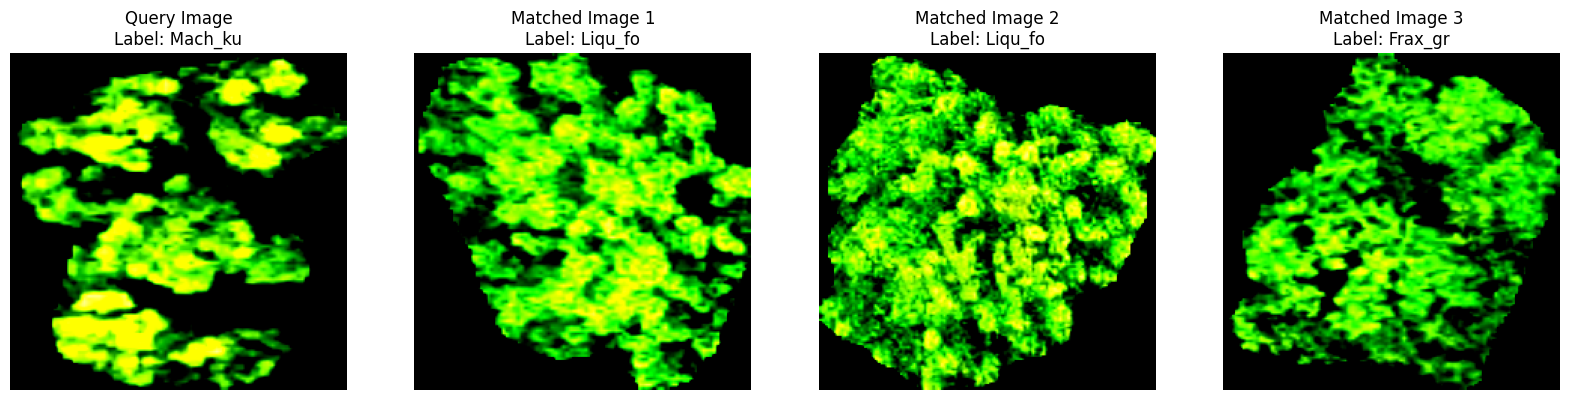

In [4]:
import matplotlib.pyplot as plt
from scipy import spatial
import random

# Load features and labels from HDF5 file
h5f = h5py.File('h:\\Yehmh\\DNDF\\101_1_focus\\DNDF_202404_101_1_ResnetFeatures.h5', 'r')
feats = h5f['dataset_1'][:]
img_labels = h5f['dataset_2'][:]
h5f.close()

# Select a random query image from the patches
random_index = random.randint(0, len(feats) - 1)
query_features = feats[random_index]
query_patch, query_label = patches_and_labels[random_index]

print(f"Query Image Label: {query_label}")

# Compute the Cosine distance between query features and dataset features
scores = []
for feat in feats:
    score = 1 - spatial.distance.cosine(query_features, feat)
    scores.append(score)
scores = np.array(scores)
rank_ID = np.argsort(scores)[::-1]
rank_score = scores[rank_ID]

# Top 3 matches to the query image (excluding the query image itself)
maxres = 4  # Including the query image
top_indices = rank_ID[1:maxres]

print(f"Top {maxres-1} images in order are:", [img_labels[index].decode('utf-8') for index in top_indices])

# Display the query image and the top matching images
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Display the query image
axs[0].imshow(query_patch.permute(1, 2, 0).numpy())
axs[0].set_title(f"Query Image\nLabel: {query_label}")
axs[0].axis('off')

# Display the top matching images
for i, idx in enumerate(top_indices):
    match_patch, match_label = patches_and_labels[idx]
    axs[i+1].imshow(match_patch.permute(1, 2, 0).numpy())
    axs[i+1].set_title(f"Matched Image {i+1}\nLabel: {match_label}")
    axs[i+1].axis('off')

plt.show()

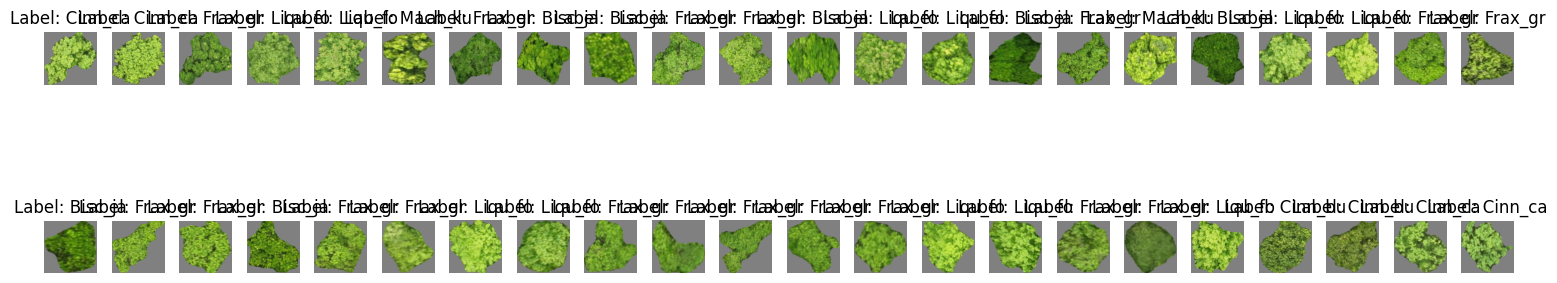

In [1]:
import torch.nn as nn
import geopandas as gpd
from shapely.geometry import mapping
import rasterio
from rasterio.features import geometry_mask
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
import h5py
import matplotlib.pyplot as plt

# Define a transformation to apply to image patches
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_polygon_patch(polygon, image_data, transform):
    """Extract image patch within a polygon and minimize shape influence."""
    # Create a mask for the polygon
    mask = geometry_mask([mapping(polygon)], transform=transform, invert=True, out_shape=image_data.shape[1:])
    
    # Create a masked image where polygon area is blurred or colored
    masked_data = np.zeros_like(image_data[:3])
    for i in range(3):
        masked_data[i] = image_data[i] * mask

    # Optionally apply a uniform color to the polygon area to reduce shape influence
    uniform_color = np.array([128, 128, 128])  # Example gray color
    masked_data[:, ~mask] = uniform_color[:, np.newaxis]  # Apply color where mask is False

    # Create a window around the polygon
    bounds = polygon.bounds
    window = rasterio.windows.from_bounds(*bounds, transform=transform)
    
    # Extract the patch
    patch = masked_data[:, window.toslices()[0], window.toslices()[1]]
    patch = np.moveaxis(patch, 0, -1)
    patch = Image.fromarray(patch.astype(np.uint8))
    return patch

def process_shapefile(shapefile_path, tif_file_path, transform):
    """Process shapefile to extract patches, features, and perform clustering."""
    polygons = gpd.read_file(shapefile_path)
    patches_and_labels = []
    with rasterio.open(tif_file_path) as src:
        image_data = src.read()

    for idx, row in polygons.iterrows():
        polygon = row.geometry
        label = row['sp']
        patch = extract_polygon_patch(polygon, image_data, src.transform)

        # Transform the patch and append to the container
        transformed_patch = transform(patch)
        patches_and_labels.append((transformed_patch, label))

    return patches_and_labels

def extract_features(patches_and_labels, model):
    """Extract features using ResNet-50."""
    features = []
    labels = []
    for patch, label in patches_and_labels:
        patch = patch.unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            feature = model(patch).squeeze().numpy()
        features.append(feature)
        labels.append(label)
    
    return features, labels

def display_patches(patches_and_labels):
    """Display image patches with their labels."""
    n = len(patches_and_labels)
    plt.figure(figsize=(15, 5))
    for i, (patch, label) in enumerate(patches_and_labels):
        # Convert the patch back to numpy array for display
        patch_np = patch.permute(1, 2, 0).numpy()
        # Unnormalize the image
        patch_np = patch_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        patch_np = np.clip(patch_np, 0, 1)  # Ensure values are in [0, 1]

        plt.subplot(2, n//2, i + 1)
        plt.imshow(patch_np)
        plt.title(f'Label: {label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
shapefile_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\202404_101_seg_shp_labeled\\DNDF101_clip_seg_labeled.shp'
tif_file_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\DNDF101_clip.tif'

patches_and_labels = process_shapefile(shapefile_path, tif_file_path, transform)

# # Initialize ResNet-50 model
# model = models.resnet50(pretrained=True)
# model = nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer

# features, labels = extract_features(patches_and_labels, model)

# # Save features and labels to HDF5 file
# h5f = h5py.File('h:\\Yehmh\\DNDF\\101_1_focus\\DNDF_202404_101_1_ResnetFeatures.h5', 'w')
# h5f.create_dataset('dataset_1', data=np.array(features))
# h5f.create_dataset('dataset_2', data=np.array(labels, dtype='S'))
# h5f.close()

# Display the image patches with their labels
display_patches(patches_and_labels)


c:\Users\user\.conda\envs\RS\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\.conda\envs\RS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


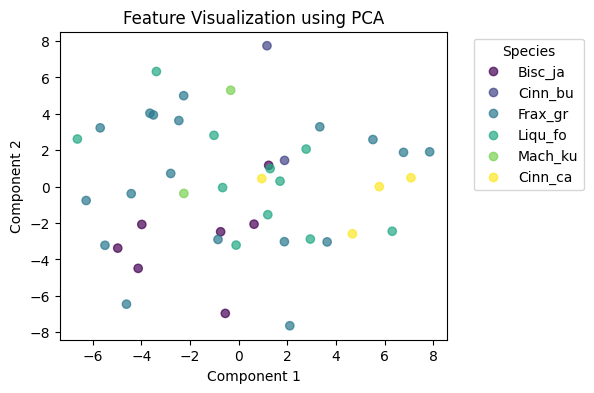

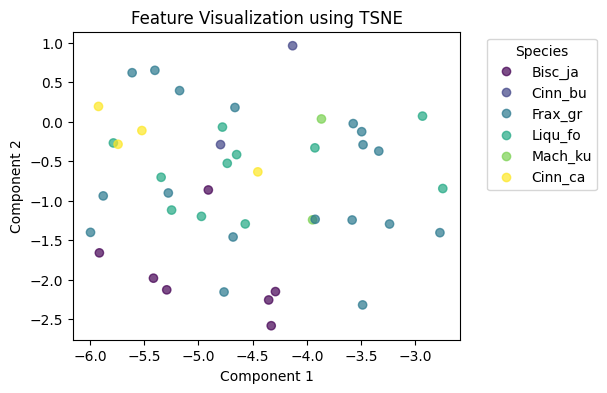

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
import geopandas as gpd
from shapely.geometry import mapping
import rasterio
from rasterio.features import geometry_mask
import numpy as np
from PIL import Image
import h5py
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Define a transformation to apply to image patches
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_polygon_patch(polygon, image_data, transform, src_transform):
    """Extract image patch within a polygon"""
    mask = geometry_mask([mapping(polygon)], transform=src_transform, invert=True, out_shape=(image_data.shape[1], image_data.shape[2]))
    masked_data = np.zeros_like(image_data[:3])
    for i in range(3):
        masked_data[i] = image_data[i] * mask
    bounds = polygon.bounds
    window = rasterio.windows.from_bounds(*bounds, transform=src_transform)
    row_off = int(window.row_off)
    col_off = int(window.col_off)
    height = int(window.height)
    width = int(window.width)
    patch = masked_data[:, row_off:row_off + height, col_off:col_off + width]
    patch = np.moveaxis(patch, 0, -1)
    patch = Image.fromarray(patch.astype(np.uint8))
    return patch

def process_shapefile(shapefile_path, tif_file_path, transform):
    """Process shapefile to extract patches, features, and perform clustering"""
    polygons = gpd.read_file(shapefile_path)
    patches_and_labels = []
    with rasterio.open(tif_file_path) as src:
        image_data = src.read()

    for idx, row in polygons.iterrows():
        polygon = row.geometry
        label = row['sp']
        patch = extract_polygon_patch(polygon, image_data, transform, src.transform)

        # Transform the patch and append to the container
        transformed_patch = transform(patch)
        patches_and_labels.append((transformed_patch, label))
        
    return patches_and_labels

# Load pre-trained ResNet-50 model and modify it to be a feature extractor
model = models.resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # Remove the final classification layer
model.eval()

def extract_features(patches_and_labels):
    """Extract features using ResNet-50"""
    features = []
    labels = []
    for patch, label in patches_and_labels:
        patch = patch.unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            feature = model(patch).squeeze().numpy()
        features.append(feature)
        labels.append(label)
    
    return features, labels

def visualize_features(features, labels, method='pca'):
    """Visualize features using PCA or t-SNE"""
    label_to_int = {label: i for i, label in enumerate(set(labels))}
    numerical_labels = [label_to_int[label] for label in labels]

    features = np.array(features)  # Convert features list to numpy array

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2)
    
    reduced_features = reducer.fit_transform(features)
    
    plt.figure(figsize=(5, 4))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=numerical_labels, cmap='viridis', alpha=0.7)
    
    # Create a legend with species names
    handles, _ = scatter.legend_elements()
    legend_labels = [label for label, int_val in label_to_int.items()]
    plt.legend(handles, legend_labels, title="Species", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title(f'Feature Visualization using {method.upper()}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Example usage
shapefile_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\202404_101_seg_shp_labeled\\DNDF101_clip_seg_labeled.shp'
tif_file_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\DNDF101_clip.tif'

patches_and_labels = process_shapefile(shapefile_path, tif_file_path, transform)

features, labels = extract_features(patches_and_labels)

# Save features and labels to HDF5 file
with h5py.File('h:\\Yehmh\\DNDF\\101_1_focus\\DNDF_202404_101_1_ResNet50Features.h5', 'w') as h5f:
    h5f.create_dataset('dataset_1', data=np.array(features))
    h5f.create_dataset('dataset_2', data=np.array(labels, dtype='S'))

# Visualize features using PCA
visualize_features(features, labels, method='pca')

# Visualize features using t-SNE
visualize_features(features, labels, method='tsne')
